# Data Source: Kaggle / UK Housing Prices Paid

https://www.kaggle.com/datasets/hm-land-registry/uk-housing-prices-paid?resource=download

In [1]:
from google.colab import drive

drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
import itertools

In [ ]:
df_raw = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/dataset/price_paid_records.csv')

In [ ]:
df_raw.head(2)

,Transaction unique identifier,Price,Date of Transfer,Property Type,Old/New,Duration,Town/City,District,County,PPDCategory Type,Record Status - monthly file only
0,{81B82214-7FBC-4129-9F6B-4956B4A663AD},25000,1995-08-18 00:00,T,N,F,OLDHAM,OLDHAM,GREATER MANCHESTER,A,A
1,{8046EC72-1466-42D6-A753-4956BF7CD8A2},42500,1995-08-09 00:00,S,N,F,GRAYS,THURROCK,THURROCK,A,A


- Transaction unique identifier: A reference number which is generated automatically recording each published sale. The number is unique and will change each time a sale is recorded.
- Price Sale: price stated on the transfer deed.
- Date of Transfer: Date when the sale was completed, as stated on the transfer deed.
- Property Type: D = Detached, S = Semi-Detached, T = Terraced, F = Flats/Maisonettes, O = Other.
- Old/New: Indicates the age of the property and applies to all price paid transactions, residential and non-residential. 
 - Y = a newly built property
 - N = an established residential building.
- Duration Relates to the tenure: F = Freehold, L= Leasehold etc.
- Town/City
- District
- County
- PPD Category Type Indicates the type of Price Paid transaction.
 - A = Standard Price Paid entry, includes single residential property sold for full market value.
 - B = Additional Price Paid entry including transfers under a power of sale/repossessions, buy-to-lets, and transfers to non-private individuals.
- Record Status - monthly file only Indicates additions, changes and deletions to the records.

# Data Cleansing

Drop irrelevant columns

In [ ]:
df_raw = df_raw.drop(['Transaction unique identifier', 'Record Status - monthly file only'], axis=1)

Convert datetime

In [ ]:
df_raw['datetime'] = pd.to_datetime(df_raw['Date of Transfer'], format='%Y-%m-%d %H:%M')
df_raw['year'] = df_raw['datetime'].dt.year
df_raw['month'] = df_raw['datetime'].dt.month
df_raw['day'] = df_raw['datetime'].dt.day

Onehot encoding for 4 categorical columns to get prepared for counting when grouping

In [ ]:
new_cols = []
for col in ['Property Type', 'Old/New', 'Duration', 'PPDCategory Type']:
    unique_values = df_raw[col].unique()
    for val in unique_values:
        new_col = col + ' ' + val
        new_cols.append(new_col)
        df_raw[new_col] = df_raw[col].apply(lambda x: 1 if x == val else 0)

In [ ]:
df_raw.columns

Index(['Price', 'Date of Transfer', 'Property Type', 'Old/New', 'Duration',
       'Town/City', 'District', 'County', 'PPDCategory Type', 'datetime',
       'year', 'month', 'day', 'Property Type T', 'Property Type S',
       'Property Type D', 'Property Type F', 'Property Type O', 'Old/New N',
       'Old/New Y', 'Duration F', 'Duration L', 'Duration U',
       'PPDCategory Type A', 'PPDCategory Type B'],
      dtype='object')


### Granularity by county and year month

In [ ]:
agg_dict = dict(zip(new_cols, ['sum']*len(new_cols)))
agg_dict['Price'] = 'mean'
df = df_raw.groupby(['County', 'year', 'month'], as_index=False).agg(agg_dict)

Save the dataframe and restart runtime to reduce RAM usage

In [ ]:
df.to_csv('/content/drive/MyDrive/Colab Notebooks/dataset/price_by_county_month.csv', index=False)

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/dataset/price_by_county_month.csv')

Combine year and month

In [ ]:
df['yearmonth'] = df['year'] * 100 + df['month']

Sort by county and yearmonth in ascending sequence

In [ ]:
df = df.sort_values(by=['County', 'yearmonth'], ignore_index=True)

Drop counties that have data less than 80% of the time or don't have data for all 6 months in 2017

In [ ]:
min_yearmonth_len = len(df['yearmonth'].unique()) * 0.8
for cty in df['County'].unique():
    if len(df[df['County']==cty]['yearmonth'].unique()) < min_yearmonth_len and \
        len(df[(df['County']==cty)&(df['year']==2017)]) < 6:
        df = df[df['County']!=cty]

## Fill time gaps

Fill with data in previous month. If there is no data in the first month, fill with 0.

In [ ]:
df1 = pd.DataFrame({'County': df['County'].unique()})
df2 = pd.DataFrame({'yearmonth': df['yearmonth'].unique()})
df_filled = pd.merge(df1.assign(key=0), df2.assign(key=0), on='key', how='outer').drop('key', axis=1)
df_filled = pd.merge(df_filled, df, on=['County', 'yearmonth'], how='left')

In [ ]:
df_filled['year'] = df_filled['yearmonth'] // 100
df_filled['month'] = df_filled['yearmonth'] % 100
for col in df_filled.columns:
    if col not in ['County', 'yearmonth', 'year', 'month']:
        df.loc[df['yearmonth']==199501, col] = 0
df_filled.fillna(method='ffill', inplace=True)

In [ ]:
df_filled.isna().any().any()

False

In [ ]:
print(f"Number of yearmonth: {len(df_filled['yearmonth'].unique())}, from {df_filled['yearmonth'][0]} to {list(df_filled['yearmonth'])[-1]}")
print(f"Number of counties: {len(df_filled['County'].unique())}")
print(f"Number of rows: {len(df_filled)}")
assert len(df_filled) == len(df_filled['yearmonth'].unique()) * len(df_filled['County'].unique())

Number of yearmonth: 270, from 199501 to 201706
Number of counties: 112
Number of rows: 30240


# EDA

Plot average price of all counties in each month

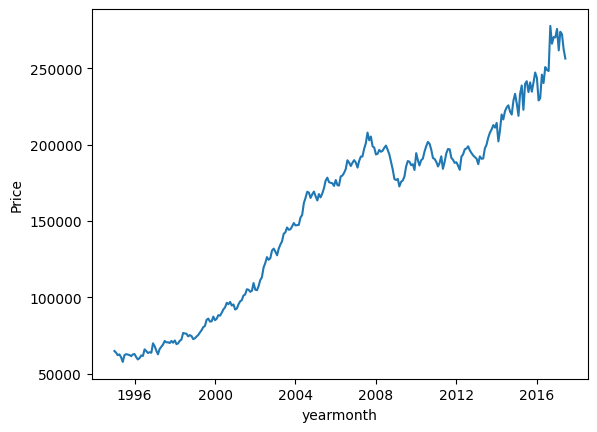

In [ ]:
yearmonth_datetime = pd.to_datetime(df_filled['yearmonth'].unique(), format='%Y%m')
mean_price = df_filled.groupby('yearmonth', as_index=False).agg({'Price': 'mean'})['Price']
plt.plot(yearmonth_datetime, mean_price)
plt.xlabel('yearmonth')
plt.ylabel('Price')
plt.show()

# Prediction

## Preprocessing

In [ ]:
df_predict = df_filled.copy()

### Create 12 lag features

In [ ]:
for i in range(1, 12+1):
    df_predict[f'price_lag_{i}'] = df_predict.groupby('County', as_index=False)['Price'].shift(i)
df_predict = df_predict[df_predict['year']>1995].reset_index(drop=True)

Create target column: 1 month ahead

In [ ]:
df_predict['price_to_predict'] = df_predict.groupby('County', as_index=False)['Price'].shift(-1)
df_predict = df_predict[df_predict['yearmonth']<201706].reset_index(drop=True)

### Target Encoding

In [ ]:
len(df_predict['County'].unique())

112

Wrong method: use a package that is not for time series task

In [ ]:
import category_encoders as ce

encoder = ce.TargetEncoder(cols=['County'])
df_encoded = encoder.fit_transform(df_predict.drop(['Price'], axis=1), df_predict['Price'])
df_predict['county_encoded_tmp'] = df_encoded['County']

In [ ]:
df_predict[['yearmonth', 'County', 'Price', 'county_encoded_tmp']].head()

,yearmonth,County,Price,county_encoded_tmp
0,199601,BATH AND NORTH EAST SOMERSET,78591.025641,235681.028135
1,199602,BATH AND NORTH EAST SOMERSET,75011.666667,235681.028135
2,199603,BATH AND NORTH EAST SOMERSET,88707.081218,235681.028135
3,199604,BATH AND NORTH EAST SOMERSET,81818.158491,235681.028135
4,199605,BATH AND NORTH EAST SOMERSET,79125.731861,235681.028135


Correct method: only use historical data to prevent data leakage

In [ ]:
for i in df_predict.index:
    target_yearmonth = df_predict.loc[i, 'yearmonth']
    county = df_predict.loc[i, 'County']
    encoding = df_predict.loc[(df_predict['County'] == county) & (df_predict['yearmonth'] <= target_yearmonth), 'Price'].mean()
    df_predict.loc[i, 'county_encoded'] = encoding

In [ ]:
df_predict[['yearmonth', 'County', 'Price', 'county_encoded']].head()

,yearmonth,County,Price,county_encoded
0,199601,BATH AND NORTH EAST SOMERSET,78591.025641,78591.025641
1,199602,BATH AND NORTH EAST SOMERSET,75011.666667,76801.346154
2,199603,BATH AND NORTH EAST SOMERSET,88707.081218,80769.924509
3,199604,BATH AND NORTH EAST SOMERSET,81818.158491,81031.983004
4,199605,BATH AND NORTH EAST SOMERSET,79125.731861,80650.732776


Create a sine feature for month

In [ ]:
df_predict['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)

In [ ]:
df_predict.to_csv('/content/drive/MyDrive/Colab Notebooks/dataset/price_ready_to_predict.csv', index=False)

In [3]:
df_predict = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/dataset/price_ready_to_predict.csv')

Separate test data

In [ ]:
df_predict.tail(2)

,County,yearmonth,year,month,Property Type T,Property Type S,Property Type D,Property Type F,Property Type O,Old/New N,...,price_lag_7,price_lag_8,price_lag_9,price_lag_10,price_lag_11,price_lag_12,price_to_predict,county_encoded_tmp,county_encoded,month_sin
28782,YORK,201704,2017,4,93.0,90.0,36.0,83.0,9.0,264.0,...,315845.347403,259352.924581,303494.971061,267358.973529,254964.720000,246568.050279,270630.500000,170087.994629,169695.250468,-0.866025
28783,YORK,201705,2017,5,61.0,78.0,44.0,37.0,10.0,220.0,...,288444.857678,315845.347403,259352.924581,303494.971061,267358.973529,254964.720000,276598.640449,170087.994629,170087.994630,-1.000000


In [4]:
train_valid = df_predict[df_predict['yearmonth']<201701]
test = df_predict[df_predict['yearmonth']>=201701]

Separate X and y

In [5]:
X = train_valid.drop(['County', 'yearmonth', 'month', 'price_to_predict', 'county_encoded_tmp'], axis=1)
y = train_valid['price_to_predict']

X_test = test.drop(['County', 'yearmonth', 'month', 'price_to_predict', 'county_encoded_tmp'], axis=1)
y_test = test['price_to_predict']

## Baseline xgboost model

In [ ]:
model = xgb.XGBRegressor()
model.fit(X, y)
y_pred = model.predict(X_test)

RMSE: the typical distance between the predicted value made by the regression model and the actual value.

R-squared: how well the predictor variables can explain the variation in the response variable.

In [ ]:
rmse_baseline = mean_squared_error(y_test, y_pred, squared=False)
r2_baseline = r2_score(y_test, y_pred)
print('RMSE:', rmse_baseline)
print('R-squared:', r2_baseline)

RMSE: 64545.75989218404
R-squared: 0.7304489827805402


## Time series cross validation and grid search

- max_depth: maximum depth of each tree in the ensemble
- gamma: minimum reduction in the loss function required to split a node in the tree. A higher gamma value makes the algorithm more conservative
- subsample: fraction of training samples that are used to train each tree in the ensemble
- colsample_bynode: fraction of features that are used to train each individual node in a tree

In [ ]:
params = {
    'max_depth': [3, 4],
    'gamma': [0.05, 0.1],
    'subsample': [0.7, 0.8],
    'colsample_bynode': [0.8, 1]
}

In [ ]:
tscv = TimeSeriesSplit(n_splits=5)
model = xgb.XGBRegressor()
grid_search = GridSearchCV(model, param_grid=params, cv=tscv, scoring='neg_root_mean_squared_error')
grid_search.fit(X, y)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, imp...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=None, ...),
             param_grid={'colsample_bynode': [0.8, 1], 'gamma': [0.05, 0.1],
                         'max_depth': [3, 4], 'subsample': [0.7, 0.8]},
             scoring='neg_root_mean_squared_error')

In [ ]:
cv_results = grid_search.cv_results_
for score, params in zip(cv_results['mean_test_score'], cv_results['params']):
    print(f"RMSE: {-score:.4f}    |    {params}")

print(f"Best RMSE: {-grid_search.best_score_:.4f}")
print(f"Best parameters: {grid_search.best_params_}")

RMSE: 24728.2237    |    {'colsample_bynode': 0.8, 'gamma': 0.05, 'max_depth': 3, 'subsample': 0.7}
RMSE: 24464.3444    |    {'colsample_bynode': 0.8, 'gamma': 0.05, 'max_depth': 3, 'subsample': 0.8}
RMSE: 24904.4053    |    {'colsample_bynode': 0.8, 'gamma': 0.05, 'max_depth': 4, 'subsample': 0.7}
RMSE: 25035.5738    |    {'colsample_bynode': 0.8, 'gamma': 0.05, 'max_depth': 4, 'subsample': 0.8}
RMSE: 24728.2237    |    {'colsample_bynode': 0.8, 'gamma': 0.1, 'max_depth': 3, 'subsample': 0.7}
RMSE: 24464.3444    |    {'colsample_bynode': 0.8, 'gamma': 0.1, 'max_depth': 3, 'subsample': 0.8}
RMSE: 24904.4053    |    {'colsample_bynode': 0.8, 'gamma': 0.1, 'max_depth': 4, 'subsample': 0.7}
RMSE: 25035.5738    |    {'colsample_bynode': 0.8, 'gamma': 0.1, 'max_depth': 4, 'subsample': 0.8}
RMSE: 24450.7568    |    {'colsample_bynode': 1, 'gamma': 0.05, 'max_depth': 3, 'subsample': 0.7}
RMSE: 24157.3607    |    {'colsample_bynode': 1, 'gamma': 0.05, 'max_depth': 3, 'subsample': 0.8}
RMSE: 24

In [ ]:
model = xgb.XGBRegressor(**grid_search.best_params_)
model.fit(X, y)
y_pred = model.predict(X_test)

In [ ]:
rmse_cv = mean_squared_error(y_test, y_pred, squared=False)
r2_cv = r2_score(y_test, y_pred)
print('RMSE:', rmse_cv)
print('R-squared:', r2_cv)

RMSE: 62461.06951101869
R-squared: 0.7475796459512976


In [ ]:
df_feat_imp = pd.DataFrame({'feature': X.columns, 'importance': model.feature_importances_}).sort_values(by=['importance'], ascending=False)
df_feat_imp.head(10)

,feature,importance
13,Price,0.289697
16,price_lag_3,0.158573
15,price_lag_2,0.108065
14,price_lag_1,0.094736
22,price_lag_9,0.083026
26,county_encoded,0.082162
17,price_lag_4,0.066358
18,price_lag_5,0.021324
24,price_lag_11,0.016325
21,price_lag_8,0.012576


## DMatrix

Dmatrix in XGBoost provides a flexible and efficient way to represent the input data and compute the necessary calculations for optimizing the model parameters during the training process, which helps to improve the accuracy and efficiency of the model fitting.

In [ ]:
feature_weights = np.ones(shape=(X.shape[1],))

dtrain = xgb.DMatrix(X, y)
dtrain.set_info(feature_weights=feature_weights)
model = xgb.train(params={}, dtrain=dtrain)

dtest = xgb.DMatrix(X_test)
dtest.set_info(feature_weights=feature_weights)
y_pred = model.predict(dtest)

rmse_dmatrix = mean_squared_error(y_test, y_pred, squared=False)
r2_dmatrix = r2_score(y_test, y_pred)
print('RMSE:', rmse_dmatrix)
print('R-squared:', r2_dmatrix)

RMSE: 62315.35399648228
R-squared: 0.7487560157502584


## DMatrix and cross validation

In [31]:
params = {
    'max_depth': [4, 5],
    'gamma': [0.01, 0.05],
    'subsample': [0.8, 1],
    'colsample_bynode': [0.2, 0.3]
}

In [34]:
feature_weights = np.ones(shape=(X.shape[1],))

fold_len = len(train_valid['yearmonth'].unique()) // 6

best_rmse = 999999
best_params = {}

for c in itertools.product(*params.values()):
    params_fold = dict(zip(params.keys(), c))

    rmse_total = 0
    for i in range(5):
        train_start = 0
        train_end = (i+1) * fold_len
        valid_start = (i+1) * fold_len
        valid_end = (i+2) * fold_len
        if i == 4:
            valid_end = len(train_valid['yearmonth'].unique())
        train_fold = train_valid.groupby('County').apply(lambda x: x.iloc[train_start:train_end]).reset_index(drop=True)
        valid_fold = train_valid.groupby('County').apply(lambda x: x.iloc[valid_start:valid_end]).reset_index(drop=True)

        X_fold = train_fold.drop(['County', 'yearmonth', 'month', 'price_to_predict', 'county_encoded_tmp'], axis=1)
        y_fold = train_fold['price_to_predict']
        X_valid_fold = valid_fold.drop(['County', 'yearmonth', 'month', 'price_to_predict', 'county_encoded_tmp'], axis=1)
        y_valid_fold = valid_fold['price_to_predict']

        dtrain = xgb.DMatrix(X_fold, y_fold)
        dtrain.set_info(feature_weights=feature_weights)
        model = xgb.train(params=params_fold, dtrain=dtrain)

        dvalid = xgb.DMatrix(X_valid_fold)
        dvalid.set_info(feature_weights=feature_weights)
        y_pred_fold = model.predict(dvalid)

        rmse_fold = mean_squared_error(y_valid_fold, y_pred_fold, squared=False)
        rmse_total += rmse_fold

    rmse_mean = rmse_total / 5
    print(f"RMSE: {rmse_mean:.4f}    |    {params_fold}")
    if rmse_mean < best_rmse:
        best_rmse = rmse_mean
        best_params = params_fold

print(f"Best RMSE: {best_rmse:.4f}")
print(f"Best parameters: {best_params}")

RMSE: 27838.4326    |    {'max_depth': 4, 'gamma': 0.01, 'subsample': 0.8, 'colsample_bynode': 0.2}
RMSE: 27620.6291    |    {'max_depth': 4, 'gamma': 0.01, 'subsample': 0.8, 'colsample_bynode': 0.3}
RMSE: 27896.4894    |    {'max_depth': 4, 'gamma': 0.01, 'subsample': 1, 'colsample_bynode': 0.2}
RMSE: 27464.4012    |    {'max_depth': 4, 'gamma': 0.01, 'subsample': 1, 'colsample_bynode': 0.3}
RMSE: 27838.4326    |    {'max_depth': 4, 'gamma': 0.05, 'subsample': 0.8, 'colsample_bynode': 0.2}
RMSE: 27620.6291    |    {'max_depth': 4, 'gamma': 0.05, 'subsample': 0.8, 'colsample_bynode': 0.3}
RMSE: 27896.4894    |    {'max_depth': 4, 'gamma': 0.05, 'subsample': 1, 'colsample_bynode': 0.2}
RMSE: 27464.4012    |    {'max_depth': 4, 'gamma': 0.05, 'subsample': 1, 'colsample_bynode': 0.3}
RMSE: 27677.1758    |    {'max_depth': 5, 'gamma': 0.01, 'subsample': 0.8, 'colsample_bynode': 0.2}
RMSE: 27798.5082    |    {'max_depth': 5, 'gamma': 0.01, 'subsample': 0.8, 'colsample_bynode': 0.3}
RMSE: 27

In [35]:
feat_imp_dict = model.get_fscore()
sorted_feat_imp_dict = {k: v for k, v in sorted(feat_imp_dict.items(), key=lambda item: item[1], reverse=True)[:10]}
sorted_feat_imp_dict

{'Price': 51.0,
 'price_lag_1': 35.0,
 'county_encoded': 26.0,
 'price_lag_3': 19.0,
 'price_lag_2': 18.0,
 'price_lag_4': 17.0,
 'price_lag_6': 17.0,
 'price_lag_8': 14.0,
 'price_lag_9': 14.0,
 'price_lag_11': 14.0}

Change feature weights

In [45]:
feature_weights = np.ones(shape=(X.shape[1],))
feature_weights[X.columns.get_loc('price_lag_1')] = 5

In [46]:
best_rmse_weighted = 999999
best_params_weighted = {}

for c in itertools.product(*params.values()):
    params_fold = dict(zip(params.keys(), c))

    rmse_total = 0
    for i in range(5):
        train_start = 0
        train_end = (i+1) * fold_len
        valid_start = (i+1) * fold_len
        valid_end = (i+2) * fold_len
        if i == 4:
            valid_end = len(train_valid['yearmonth'].unique())
        train_fold = train_valid.groupby('County').apply(lambda x: x.iloc[train_start:train_end]).reset_index(drop=True)
        valid_fold = train_valid.groupby('County').apply(lambda x: x.iloc[valid_start:valid_end]).reset_index(drop=True)

        X_fold = train_fold.drop(['County', 'yearmonth', 'month', 'price_to_predict', 'county_encoded_tmp'], axis=1)
        y_fold = train_fold['price_to_predict']
        X_valid_fold = valid_fold.drop(['County', 'yearmonth', 'month', 'price_to_predict', 'county_encoded_tmp'], axis=1)
        y_valid_fold = valid_fold['price_to_predict']

        dtrain = xgb.DMatrix(X_fold, y_fold)
        dtrain.set_info(feature_weights=feature_weights)
        model = xgb.train(params=params_fold, dtrain=dtrain)

        dvalid = xgb.DMatrix(X_valid_fold)
        dvalid.set_info(feature_weights=feature_weights)
        y_pred_fold = model.predict(dvalid)

        rmse_fold = mean_squared_error(y_valid_fold, y_pred_fold, squared=False)
        rmse_total += rmse_fold

    rmse_mean = rmse_total / 5
    print(f"RMSE: {rmse_mean:.4f}    |    {params_fold}")
    if rmse_mean < best_rmse_weighted:
        best_rmse_weighted = rmse_mean
        best_params_weighted = params_fold

print(f"Best RMSE: {best_rmse_weighted:.4f}")
print(f"Best parameters: {best_params_weighted}")

RMSE: 26718.4936    |    {'max_depth': 4, 'gamma': 0.01, 'subsample': 0.8, 'colsample_bynode': 0.2}
RMSE: 27104.4421    |    {'max_depth': 4, 'gamma': 0.01, 'subsample': 0.8, 'colsample_bynode': 0.3}
RMSE: 27314.4046    |    {'max_depth': 4, 'gamma': 0.01, 'subsample': 1, 'colsample_bynode': 0.2}
RMSE: 27045.3531    |    {'max_depth': 4, 'gamma': 0.01, 'subsample': 1, 'colsample_bynode': 0.3}
RMSE: 26718.4936    |    {'max_depth': 4, 'gamma': 0.05, 'subsample': 0.8, 'colsample_bynode': 0.2}
RMSE: 27104.4421    |    {'max_depth': 4, 'gamma': 0.05, 'subsample': 0.8, 'colsample_bynode': 0.3}
RMSE: 27314.4046    |    {'max_depth': 4, 'gamma': 0.05, 'subsample': 1, 'colsample_bynode': 0.2}
RMSE: 27045.3531    |    {'max_depth': 4, 'gamma': 0.05, 'subsample': 1, 'colsample_bynode': 0.3}
RMSE: 27074.0581    |    {'max_depth': 5, 'gamma': 0.01, 'subsample': 0.8, 'colsample_bynode': 0.2}
RMSE: 29005.9540    |    {'max_depth': 5, 'gamma': 0.01, 'subsample': 0.8, 'colsample_bynode': 0.3}
RMSE: 29

In [47]:
if best_rmse < best_rmse_weighted:
    feature_weights = np.ones(shape=(X.shape[1],))

In [49]:
dtrain = xgb.DMatrix(X, y)
dtrain.set_info(feature_weights=feature_weights)
model = xgb.train(params=best_params, dtrain=dtrain)

dtest = xgb.DMatrix(X_test)
dtest.set_info(feature_weights=feature_weights)
y_pred = model.predict(dtest)

rmse_dmatrix_cv = mean_squared_error(y_test, y_pred, squared=False)
r2_dmatrix_cv = r2_score(y_test, y_pred)
print('RMSE:', rmse_dmatrix_cv)
print('R-squared:', r2_dmatrix_cv)

RMSE: 61414.3705132107
R-squared: 0.7559686915968393


In [50]:
feat_imp_dict = model.get_fscore()
sorted_feat_imp_dict = {k: v for k, v in sorted(feat_imp_dict.items(), key=lambda item: item[1], reverse=True)[:10]}
sorted_feat_imp_dict

{'Price': 25.0,
 'price_lag_1': 23.0,
 'price_lag_2': 12.0,
 'price_lag_5': 12.0,
 'price_lag_3': 10.0,
 'price_lag_4': 9.0,
 'price_lag_6': 9.0,
 'price_lag_8': 8.0,
 'county_encoded': 7.0,
 'price_lag_9': 6.0}

## Compare Models

In [51]:
pd.DataFrame({
    'model': ['baseline', 'cv', 'dmatrix', 'dmatrix_cv'],
    'rmse': [rmse_baseline, rmse_cv, rmse_dmatrix, rmse_dmatrix_cv],
    'r2': [r2_baseline, r2_cv, r2_dmatrix, r2_dmatrix_cv]
})

,model,rmse,r2
0,baseline,64545.759892,0.730449
1,cv,62461.069511,0.747580
2,dmatrix,62315.353996,0.748756
3,dmatrix_cv,61414.370513,0.755969


# Error Analysis

Plot y_true vs y_pred

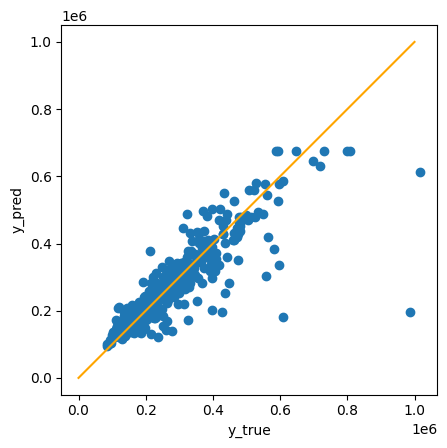

In [52]:
plt.scatter(y_test, y_pred)
plt.plot([0, 1000000], [0, 1000000], c='orange')
plt.xlabel('y_true')
plt.ylabel('y_pred')
plt.axis('scaled')
plt.show()

## Define a metric to measure error

Total distance between y_true and y_pred compared to y_true, the lower the better

In [16]:
def measure_error(y_true, y_pred):
    return np.sum(np.abs(y_true - y_pred)) / np.sum(y_true)

## Find counties that have highest errors

In [53]:
df_result = pd.DataFrame({'county': test['County'], 'yearmonth': [201701, 201702, 201703, 201704, 201705]*(len(test['County'])//5), 
                          'y_true': y_test, 'y_pred': y_pred}).reset_index(drop=True)

In [54]:
df_result.head()

,county,yearmonth,y_true,y_pred
0,BATH AND NORTH EAST SOMERSET,201701,372461.143541,406510.5625
1,BATH AND NORTH EAST SOMERSET,201702,460664.207317,411866.0000
2,BATH AND NORTH EAST SOMERSET,201703,383016.081448,400920.7500
3,BATH AND NORTH EAST SOMERSET,201704,474006.633333,429648.8125
4,BATH AND NORTH EAST SOMERSET,201705,351704.869048,435239.2500


In [55]:
error_lst = []
for cty in test['County'].unique():
    error = measure_error(df_result.loc[df_result['county']==cty, 'y_true'], df_result.loc[df_result['county']==cty, 'y_pred'])
    error_lst.append({'county': cty, 'error': error})
df_error = pd.DataFrame(error_lst).sort_values(by=['error'], ascending=False).reset_index(drop=True)

In [56]:
df_error.head()

,county,error
0,CITY OF KINGSTON UPON HULL,0.634665
1,NEWPORT,0.490854
2,ISLES OF SCILLY,0.329950
3,BLACKBURN WITH DARWEN,0.306586
4,RHONDDA CYNON TAFF,0.295690


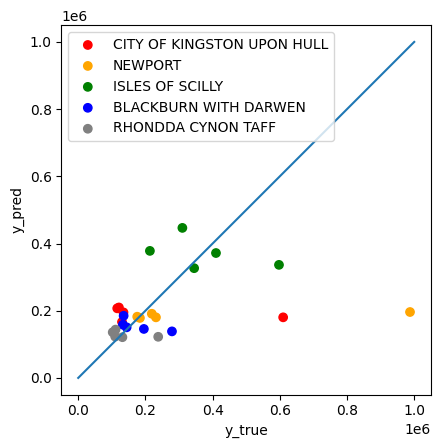

In [57]:
top_5_error_cty = list(df_error['county'][:5])
colors = dict(zip(top_5_error_cty, ['red', 'orange', 'green', 'blue', 'gray']))
for cty in top_5_error_cty:
    plt.scatter(
        df_result.loc[df_result['county']==cty, 'y_true'], 
        df_result.loc[df_result['county']==cty, 'y_pred'], 
        c = df_result.loc[df_result['county']==cty, 'county'].map(colors),
        label = cty
    )

plt.plot([0, 1000000], [0, 1000000])

plt.xlabel('y_true')
plt.ylabel('y_pred')
plt.legend()
plt.axis('scaled')
plt.show()

## Plot historical trends

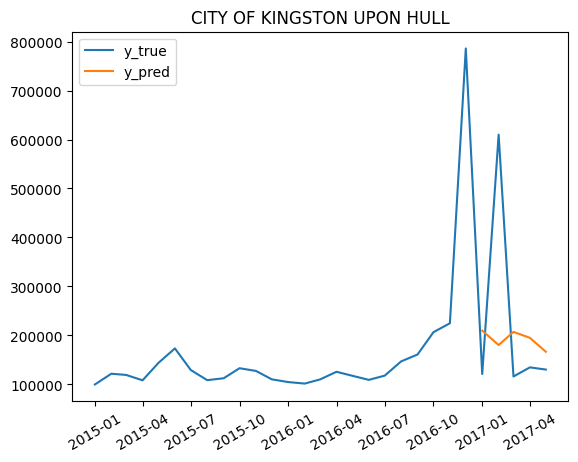

In [58]:
yearmonth_datetime1 = pd.to_datetime(df_predict[df_predict['yearmonth']>=201501]['yearmonth'].unique(), format='%Y%m')
plt.plot(yearmonth_datetime1, df_predict.loc[(df_predict['yearmonth']>=201501)&(df_predict['County']=='CITY OF KINGSTON UPON HULL'), 'price_to_predict'], label='y_true')

yearmonth_datetime2 = pd.to_datetime(df_result['yearmonth'].unique(), format='%Y%m')
plt.plot(yearmonth_datetime2, df_result.loc[df_result['county']=='CITY OF KINGSTON UPON HULL', 'y_pred'], label='y_pred')

plt.legend()
plt.title('CITY OF KINGSTON UPON HULL')
plt.xticks(rotation=30)
plt.show()

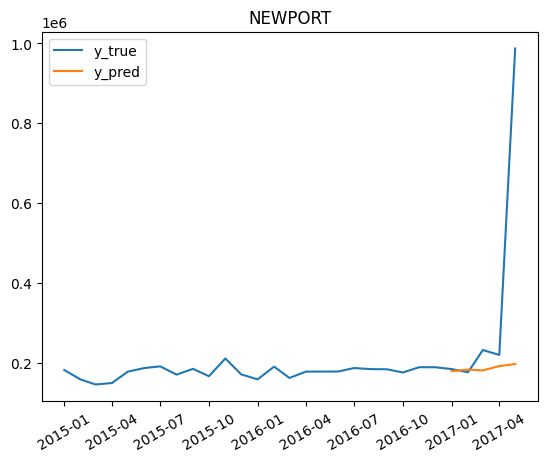

In [59]:
yearmonth_datetime1 = pd.to_datetime(df_predict[df_predict['yearmonth']>=201501]['yearmonth'].unique(), format='%Y%m')
plt.plot(yearmonth_datetime1, df_predict.loc[(df_predict['yearmonth']>=201501)&(df_predict['County']=='NEWPORT'), 'price_to_predict'], label='y_true')

yearmonth_datetime2 = pd.to_datetime(df_result['yearmonth'].unique(), format='%Y%m')
plt.plot(yearmonth_datetime2, df_result.loc[df_result['county']=='NEWPORT', 'y_pred'], label='y_pred')

plt.legend()
plt.title('NEWPORT')
plt.xticks(rotation=30)
plt.show()

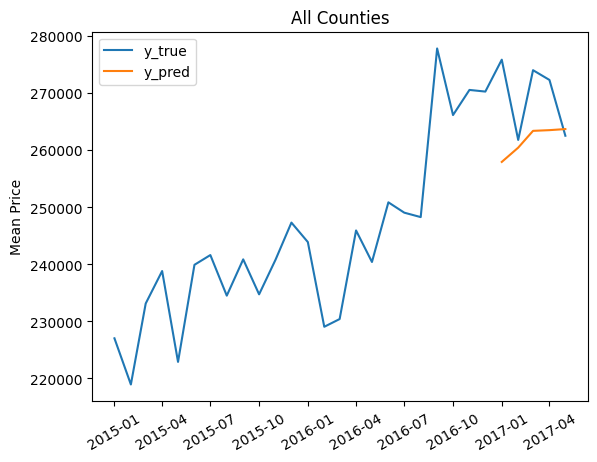

In [60]:
df_tmp = df_predict[df_predict['yearmonth']>=201501]
yearmonth_datetime1 = pd.to_datetime(df_tmp['yearmonth'].unique(), format='%Y%m')
mean_price1 = df_tmp.groupby('yearmonth', as_index=False).agg({'Price': 'mean'})['Price']
plt.plot(yearmonth_datetime1, mean_price1, label='y_true')

yearmonth_datetime2 = pd.to_datetime(df_result['yearmonth'].unique(), format='%Y%m')
mean_price2 = df_result.groupby('yearmonth', as_index=False).agg({'y_pred': 'mean'})['y_pred']
plt.plot(yearmonth_datetime2, mean_price2, label='y_pred')

plt.legend()
plt.ylabel('Mean Price')
plt.title('All Counties')
plt.xticks(rotation=30)
plt.show()

Percentage of under-predict data

In [61]:
df_result[df_result['y_pred']<df_result['y_true']].shape[0] / df_result.shape[0]

0.4375

Further work:
- Spikes for specific couties and months need to be handled